#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [ ]:
!pip install -U scikit-learn -q
!pip install phik -q

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import phik
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit #, RandomizedSearchCV #, cross_val_score
from sklearn.linear_model import LinearRegression #, LogisticRegression #, Ridge
from sklearn.metrics import mean_squared_error, root_mean_squared_error #, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder #, LabelEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline #, make_pipeline
from sklearn.compose import ColumnTransformer #, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor #, DecisionTreeClassifier
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor

In [ ]:
sklearn.__version__

'1.4.1.post1'

In [ ]:
try:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('C:/Users/Student/Desktop/taxi.csv', index_col=[0], parse_dates=[0])

In [ ]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [ ]:
data.isna().sum()

num_orders    0
dtype: int64

In [ ]:
data.index.is_monotonic

True

In [ ]:
data = data.resample('1H').sum()

In [ ]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Данные выгрузились корректно, столбец datetime установлен индексом, временной ряд монотонный (данные в хронологическом порядке), с марта по август 2018. Выполнено ресемплирование по одному часу (количество заказов просуммировано почасово), в результате чего из 26496 строк получилось 4416.

## Анализ

Построим графики тренда, сезонности и остатков:

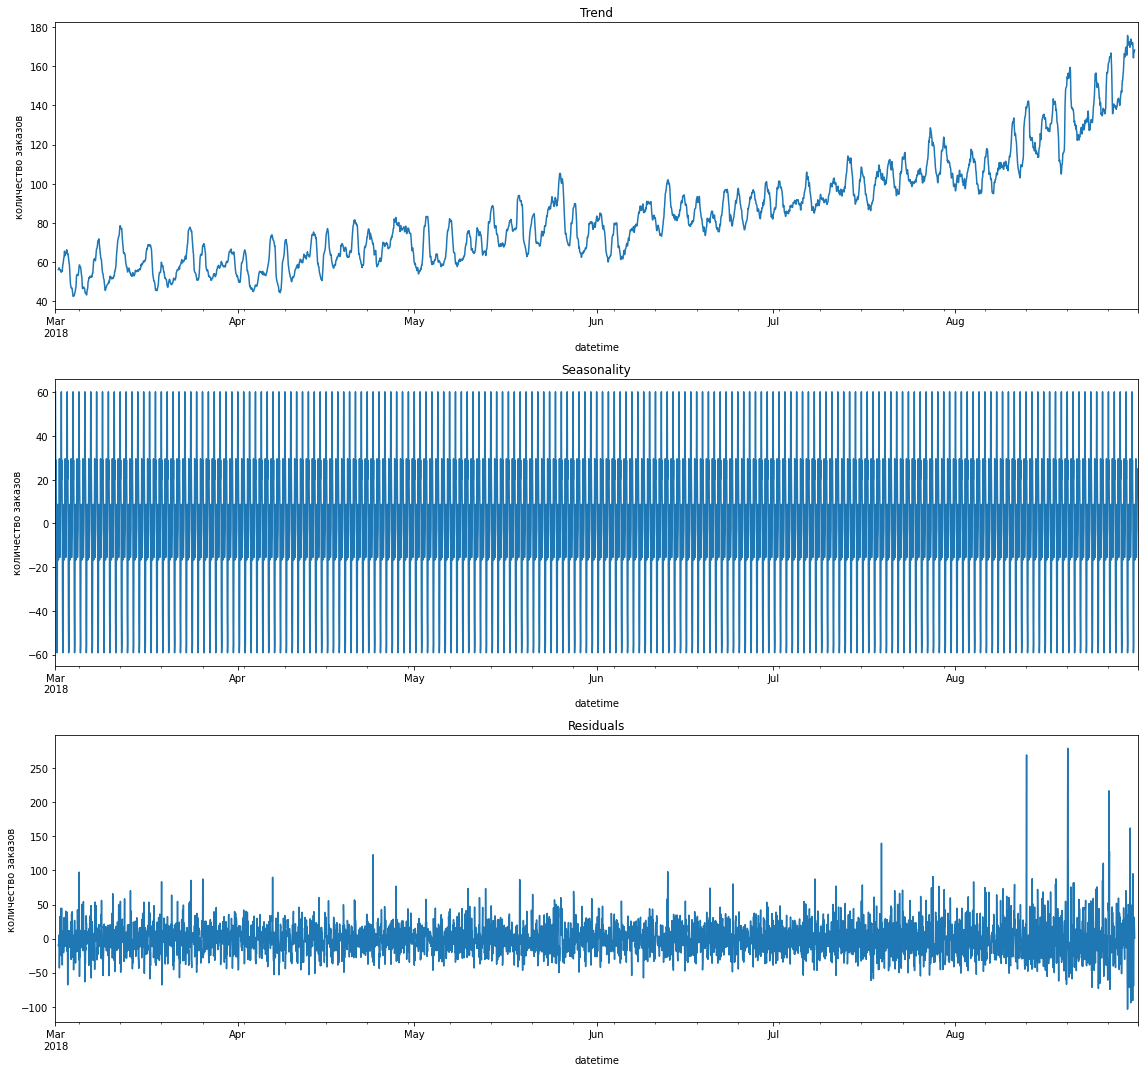

In [ ]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(16, 15))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca(), ylabel='количество заказов')
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), ylabel='количество заказов')
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), ylabel='количество заказов')
plt.title('Residuals')
plt.tight_layout();

График тренда показывает рост заказов от месяца к месяцу, несмотря на колебания внутри месяцев. Но у нас только 6 месяцев с марта по август, неизвестно, что происходит осенью и зимой.

График сезонности показывает одинаковые очень частые колебания. Надо уменьшить период, чтобы рассмотреть.

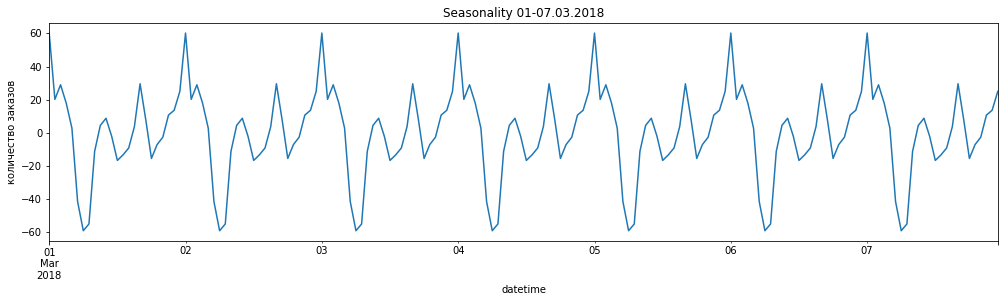

In [ ]:
decomposed.seasonal['2018-03-01':'2018-03-07'].plot(ax=plt.gca(), figsize=(17, 4), ylabel='количество заказов')
plt.title('Seasonality 01-07.03.2018');

Посмотрели сезонность за первую неделю. Каждый день одинаковые колебания.

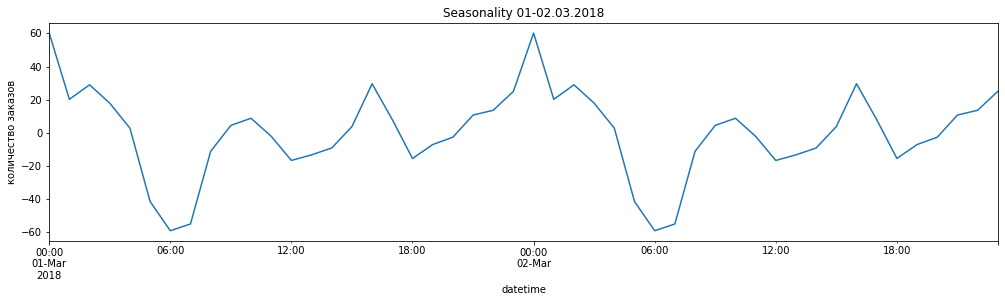

In [ ]:
decomposed.seasonal['2018-03-01':'2018-03-02'].plot(ax=plt.gca(), figsize=(17, 4), ylabel='количество заказов')
plt.title('Seasonality 01-02.03.2018');

А если взять 2 дня, то видно, что в полночь пик заказов, а к 6 утра резкий спад (видимо утром нет рейсов, а с ночных рейсов уже все разъехались). Каждый день одинаковый график - соответствует расписанию вылетов-прилётов.

In [ ]:
data['rolling_mean'] = data.rolling(24, closed='left').mean()

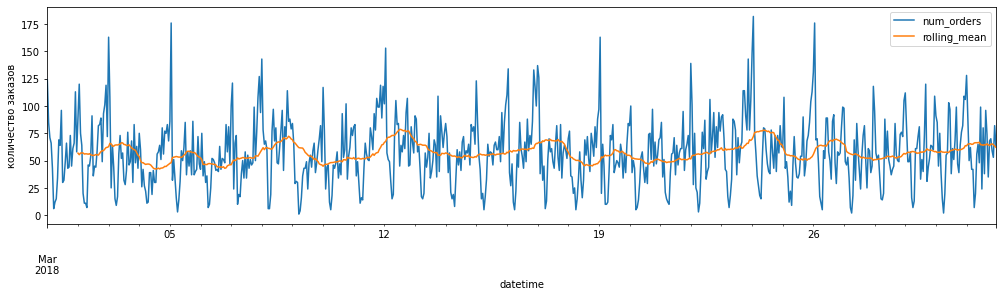

In [ ]:
data['2018-03-01':'2018-03-31'].plot(figsize=(17, 4), ylabel='количество заказов');

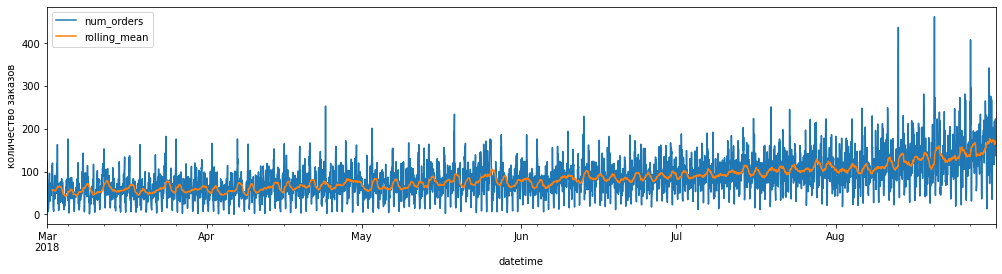

In [ ]:
data.plot(figsize=(17, 4), ylabel='количество заказов');

Нарисуем скользящее среднее за 24 часа, эта линия сильно сглаживает общий график заказов за март месяц (у нас самые сильные колебания - суточные).

Если посмотреть скользящее среднее за весь период, то видно, как к августу оно увеличивается. Наш временной ряд нестационарен.

Добавим признаки:
- день недели (сделаем, чтоб понедельник был 1, воскресенье 7),
- час (призак суточных колебаний).

In [ ]:
data['dayofweek'] = data.index.dayofweek+1 # пн-1, вс-7
#data['month'] = data.index.month
data['hour'] = data.index.hour
data.head()

,num_orders,rolling_mean,dayofweek,hour
datetime,,,,
2018-03-01 00:00:00,124,NaN,4,0
2018-03-01 01:00:00,85,NaN,4,1
2018-03-01 02:00:00,71,NaN,4,2
2018-03-01 03:00:00,66,NaN,4,3
2018-03-01 04:00:00,43,NaN,4,4


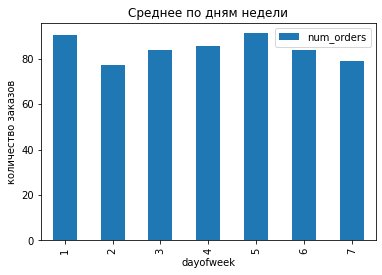

In [ ]:
data.pivot_table(index='dayofweek', values='num_orders', aggfunc='mean').plot(kind='bar', title='Среднее по дням недели',
                                                                              ylabel='количество заказов');

Посмотрим столбчатые диаграммы по дням недели (в т.ч. в разрезе месяцев) за весь период. Больше всего заказов по понедельникам и пятницам, меньше всего - вторник и воскресенье.

Также посчитаем разности временного ряда (ещё 7 новых признаков).

In [ ]:
for lag in range(1, 8):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4416 non-null   int64  
 1   rolling_mean  4392 non-null   float64
 2   dayofweek     4416 non-null   int64  
 3   hour          4416 non-null   int64  
 4   lag_1         4415 non-null   float64
 5   lag_2         4414 non-null   float64
 6   lag_3         4413 non-null   float64
 7   lag_4         4412 non-null   float64
 8   lag_5         4411 non-null   float64
 9   lag_6         4410 non-null   float64
 10  lag_7         4409 non-null   float64
dtypes: float64(8), int64(3)
memory usage: 543.0 KB


,num_orders,rolling_mean,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
datetime,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,4,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,4,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,4,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,4,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN


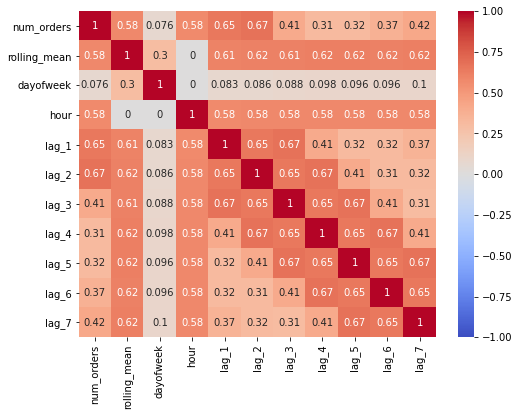

In [ ]:
interval_cols = data.select_dtypes(include='number').columns.drop(['dayofweek', 'hour'])

plt.figure(figsize = (8,6))
sns.heatmap(data.phik_matrix(interval_cols=interval_cols), annot=True, cmap='coolwarm', vmin=-1)
plt.show()

Посмотрим матрицу корреляций - мультиколлинеарности между признаками нет.

## Обучение

Разбиваем данные на выборки (тестовая 10%, тренировочная 90%), удаляем строки с пропусками. Целевой признак - `num_orders`, количество заказов. Новые признаки "день недели" и "час" будем рассматривать как категориальные.

In [ ]:
train, test = train_test_split(data, shuffle=False, test_size=0.1) # тестовая 10% данных
train = train.dropna()

print(train.index.min(), train.index.max(), '- тренировочная')
print(test.index.min(), test.index.max(), '- тестовая')

X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

print('\nКоличественные признаки:', interval_cols.tolist())
print('Признаки для OneHotEncoder:', data.columns.drop(interval_cols).tolist())

2018-03-02 00:00:00 2018-08-13 13:00:00 - тренировочная
2018-08-13 14:00:00 2018-08-31 23:00:00 - тестовая

Количественные признаки: ['num_orders', 'rolling_mean', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7']
Признаки для OneHotEncoder: ['dayofweek', 'hour']


In [ ]:
RANDOM_STATE = 42

data_preprocessor = ColumnTransformer(
    [
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), data.columns.drop(interval_cols)),
        ('num', StandardScaler(), interval_cols.drop('num_orders'))
    ],
    remainder='passthrough')

pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

In [ ]:
param_grid = [
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,15),
        'models__min_samples_split': range(2,15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # словарь для модели LGBMRegressor()
    {
        'models': [LGBMRegressor(verbose=-1, random_state=RANDOM_STATE)],
        #'models__n_estimators': [50, 100],
        'models__max_depth': range(5,8),
       # 'models__num_leaves': range(10,16),
        'models__learning_rate': [0.1, 0.4, 0.7],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [ ]:
#%%time
grid = GridSearchCV(
    pipe_final,
    param_grid=param_grid,
    cv=TimeSeriesSplit(),
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

In [ ]:
grid.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', grid.best_estimator_)
print('Метрика RMSE на кросс-валидации:', round(-grid.best_score_, 4))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  Index(['dayofweek', 'hour'], dtype='object')),
                                                 ('num', MinMaxScaler(),
                                                  Index(['rolling_mean', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6',
       'lag_7'],
      dtype='object'))])),
                ('models', LinearRegression())])
Метрика RMSE на кросс-валидации: 25.6379


В пайплайне обучены 3 модели:
- линейная регрессия,
- дерево решений (с гиперпараметрами max_depth и min_samples_split),
- LigthGBM (с гиперпараметрами max_depth и learning_rate).

Лучшей моделью оказалась **линейная регрессия**, её RMSE на кросс-валидации 25.6379.

## Тестирование

In [ ]:
y_pred = grid.best_estimator_.predict(X_test)
#print('Метрика RMSE на тестовой выборке:', round(mean_squared_error(y_test, y_pred, squared=False), 4))
print('Метрика RMSE на тестовой выборке:', round(root_mean_squared_error(y_test, y_pred), 4))

Метрика RMSE на тестовой выборке: 42.5746


In [ ]:
dummy_r = DummyRegressor(strategy="median")
dummy_r.fit(X_train, y_train)
round(root_mean_squared_error(y_test, dummy_r.predict(X_test)), 4)

87.1528

На тестовой выборке лучшая модель (линейная регрессия) показала **RMSE 42.5746**, что меньше максимально допустимых 48. Условие **выполняется**. В сравнении с DummyRegressor (который вместо прогноза по признакам выдаёт "среднепотолочные" значения) наша модель в 2 раза лучше.

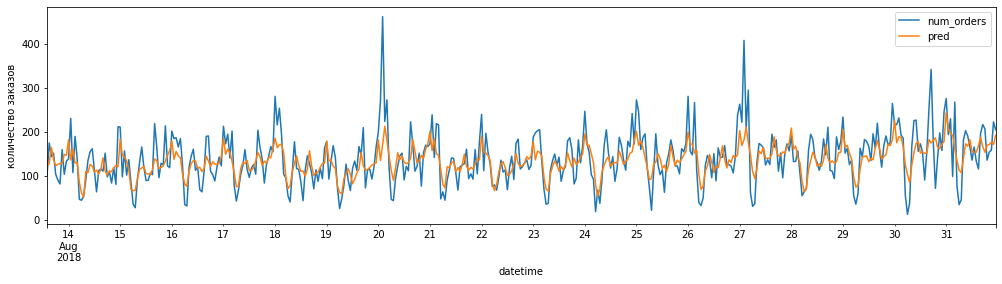

In [ ]:
test_pred = pd.DataFrame(y_test)
test_pred['pred'] = y_pred
test_pred.plot(figsize=(17, 4), ylabel='количество заказов')
plt.show()

На графике оранжевые предсказания на фоне синих фактических (тестовых) заказов. Общую тенденцию модель уловила хорошо, но большие пики и провалы не предсказала. На нашем тренде (и особенно на графике со скользящим средним) в разделе 2 видно, как в августе не только растёт число заказов, но и увеличивается часовой размах (пики выше, провалы ниже, чем в предыдущих месяцах), а у нас трейн и тест поделены 13 августа, поэтому в обучение модели попало мало августовских больших колебаний числа заказов.

**Общий вывод:**

Мы сгруппировали заказы такси почасово, проверили временной ряд на стационарность при помощи скользящего среднего. Поскольку среднее растёт в течение периода времени (март-август 2018), временной ряд нестационарный, его труднее предсказывать.

Кроме роста к августу, временной ряд имеет ежедневные одинаковые колебания (в зависимости от расписания рейсов в аэропорту), а также колебания по дням недели, поэтому добавлены новые признаки "час" и "день недели" (и 7 признаков разности временного ряда).

В пайплайне выбрали лучшую модель из трёх, это линейная регрессия. На тестовой выборке лучшая модель показала **RMSE 42.5746**, что соответствует условию (до 48).